In [ ]:
# Incase we have to clear all variables
%reset -f

In [25]:
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']

from dimer_setup import *
from sparse_utils import *

In [ ]:
import matplotlib.pyplot as plt
from heatmap_setup import calculate_steadystate
from scipy.sparse.linalg import eigs, lgmres
from scipy.sparse import csc_matrix
import time
import numpy as np

### Example Liouvillian

In [26]:
w_2 = 8000.
alpha = 20.

N = 5
pap = alpha_to_pialpha_prop(alpha, w_2)
wc = 53.
w_0 = 200.
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300.,
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=N, Gamma=Gamma, w_0=300.,
                                 silent=True, exc_diff=2)

H, L = get_H_and_L(PARAMS,silent=False)
L_tidy = chop(L, threshold=1e-6)

The operators took 5.47260713577 and have dimension 96.
Building the RC Liouvillian took 5.493 seconds.
****************************************************************
It is 9216by9216. The full basis would be 10000by10000
It took  4.86163401604  seconds to build the Non-secular RWA Liouvillian


In [21]:
ti = time.time()
ssL, info = calculate_steadystate(H, L, fill_factor=500, persistent=False)
print time.time()-ti; ti = time.time()


2260.5865469


KeyboardInterrupt: 

In [27]:
ssLt, info = calculate_steadystate(H, L_tidy, fill_factor=500, persistent=False)
print time.time()-ti
rho_size = ssL.shape[0]**2

KeyboardInterrupt: 

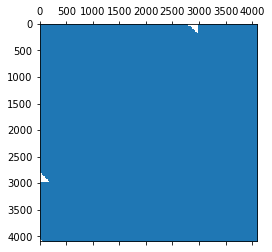

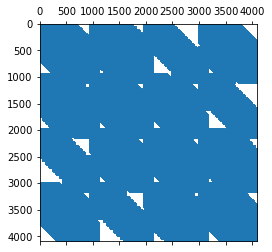

In [11]:
visualise_sparse(L)
visualise_sparse(L_tidy)

In [7]:
print nonzero_elements(L)
print nonzero_elements(L_tidy)
print total_elements(L)
print 100*float(nonzero_elements(L))/total_elements(L)
print 100*float(nonzero_elements(L_tidy))/total_elements(L)

545465
243001
16777216
3.25122475624
1.44839882851


Total error per nz dm element due to chop: (-4.47954201036e-09+3.23117426779e-26j)


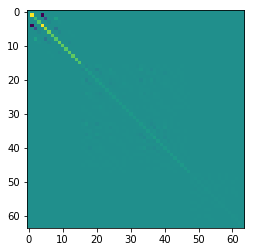

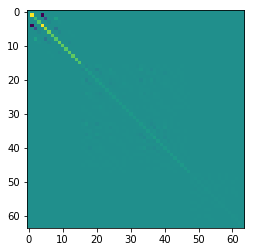

In [12]:
print "Total error per nz dm element due to chop: {}".format(np.sum(ssL.full()-ssLt.full())/nonzero_elements(ssL)) 

visualise_dense(ssL)
visualise_dense(ssLt)


# For N=6, with no 

In [4]:
from heatmap_setup import steadystate

w_2 = 8000.
alpha = 20.

N = 6
pap = alpha_to_pialpha_prop(alpha, w_2)
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300.,
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=N, Gamma=200., w_0=300.,
                                 silent=True, exc_diff=N)
from numpy.linalg import norm
def estimateCondition(M):
    vec = np.ones((1, M.shape[0])).T
    return norm(M.dot(vec), np.inf)

In [6]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict):
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i])
        print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i])
    plt.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")
    plt.show()


def method_comparison(N_i, N_f, plot=True):
    methods = ['direct','power']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for N in N_vals:
        PARAMS.update({'N_1':N, 'N_2':N, 'exc_diff':int(1.5*N)})
        H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7)
        exps = make_expectation_operators(PARAMS)
        for method in methods:
            try:
                M=None
                if "iterative" in method:
                    ti = time.time()
                    M = build_preconditioner(H[1], [L], fill_factor=1000,
                                           drop_tol=1e-4, use_rcm=True, ILU_MILU='smilu_2')
                    print "Building preconditioner ({}) took {} seconds".format(estimateCondition(M), 
                                                                                     time.time()-ti)
                ss, full_info = steadystate(H[1], [L], method=method, M=M,
                                           use_precond=True, use_rcm=True, 
                                           return_info=True, tol=1e-8, maxiter=10000)

                print method, full_info['solution_time']
                info = full_info['solution_time']

                coh = (exps['site_coherence']*ss).tr()
                try:
                    data_dict[method].append(coh)
                    info_dict[method].append(info)
                except KeyError:
                    data_dict[method] = [coh]
                    info_dict[method] = [info]
            except Exception as err:
                raise
                print "{} failed due to : {}".format(method, err)
                try:
                    data_dict[method].append(None)
                    info_dict[method].append(None)
                except KeyError:
                    data_dict[method] = [None]
                    info_dict[method] = [None]
    if plot:
        method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict, info_dict = method_comparison(2,8)

The operators took 0.415843009949 and have dimension 16.
Building the RC Liouvillian took 0.432 seconds.
****************************************************************
It is 256by256. The full basis would be 256by256
It took  0.475606918335  seconds to build the Non-secular RWA Liouvillian
direct 0.0080771446228
power 0.0109710693359
The operators took 0.76158118248 and have dimension 36.
Building the RC Liouvillian took 0.771 seconds.
****************************************************************
It is 1296by1296. The full basis would be 1296by1296
It took  0.791532993317  seconds to build the Non-secular RWA Liouvillian
direct 0.0664381980896
power 0.0514991283417
The operators took 1.81962299347 and have dimension 64.
Building the RC Liouvillian took 1.828 seconds.
****************************************************************
It is 4096by4096. The full basis would be 4096by4096
It took  2.04300689697  seconds to build the Non-secular RWA Liouvillian
direct 1.30432486534
power

Exception: Failed to find steady state after 10000 iterations

# Plotting methods

In [ ]:
def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = N+PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': N+y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    print ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array


def heatmap_plotter(num, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    info = info_array[0][0]
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    
    ss_array = steadystate_observable(ss_array, PARAMS, observable)

    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        if reverse_x:
            x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    
    print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

In [ ]:
heatmap_plotter(2, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True)